# 실험 결과

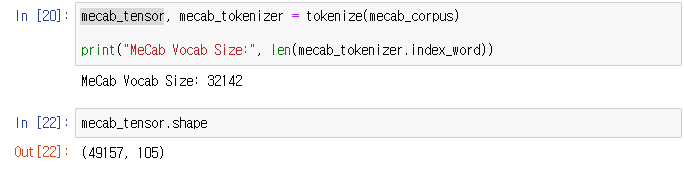

- 전처리를 거치지않은 Mecab은 32142 보카사이즈
- 그리고 토크나이즈 이후 최대 길이는 105 였다


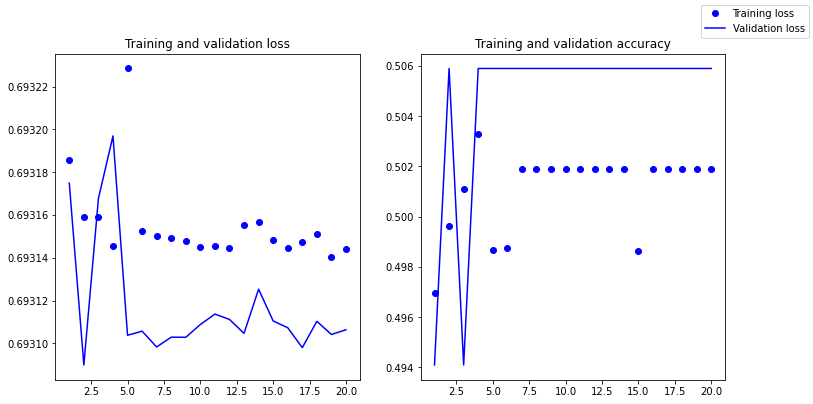

In [2]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

In [3]:


# 데이터를 읽어봅시다. 

traindata_path = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/ratings_train.txt'
testdata_path = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/ratings_test.txt'

train_data = pd.read_table(traindata_path)
test_data = pd.read_table(testdata_path)

train_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


# 중복 결측치 제거

In [4]:
train_data.drop_duplicates(subset=['document'], inplace=True)
train_data = train_data.dropna(how = 'any') 
test_data.drop_duplicates(subset=['document'], inplace=True)
test_data = test_data.dropna(how = 'any') 

In [7]:
raw_cop = list(train_data['document'])
train_label = train_data['label']

In [8]:
def preprocess_sentence(sentence):
    # 온점 사이에 공백을 넣기
#     sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    # 연속 공백을 하나의 공백으로 변환
#     sentence = re.sub(r'[" "]+', " ", sentence)
    # 큰따옴표를 제거
#     sentence = re.sub(r'["]', '', sentence)
    # 완성되지 않은 표현을 제거 (ㅜㅜ 또는 ㅇㅇ 같은 느낌)
#     sentence = re.sub(r"[ㄱ-ㅎㅏ-ㅣ]+", "", sentence)
    # 양쪽 공백을 제거
    sentence = sentence.strip()
    return sentence

In [9]:
max_len = 145
min_len = 0

# cleaned_corpus = preprocess_sentence(raw_cop)

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [preprocess_sentence(s) for s in raw_cop if (len(s) < max_len) & (len(s) >= min_len)]

In [10]:
len(filtered_corpus)

49157

In [12]:
filtered_corpus[0]

'굳 ㅋ'

In [16]:
from konlpy.tag import Mecab

mecab = Mecab()

In [18]:
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [19]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [20]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 32142


In [22]:
mecab_tensor.shape

(49157, 105)

In [23]:
mecab_tensor[0]

array([739, 151,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0], dtype=int32)

In [24]:
# validation set 20000건 분리
X_val = mecab_tensor[:10000]   
y_val = train_label[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = mecab_tensor[10000:]
partial_y_train = train_label[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(39157, 105)
(39157,)


In [29]:
vocab_size = len(mecab_tokenizer.index_word) # 어휘 사전의 크기입니다 - word_to_index의 길이 load_data 보면 설정해줬음 10000개로
word_vector_dim = 16   # 학습시키면서 진행할테니 - 일단 16차원으로 적어둔다

model3 = tf.keras.Sequential()
model3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model3.add(tf.keras.layers.Dense(8, activation='relu'))
model3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

In [30]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
77/77 [==============================] - 2s 14ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 2/20
77/77 [==============================] - 1s 8ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 3/20
77/77 [==============================] - 1s 8ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6932 - val_accuracy: 0.4941
Epoch 4/20
77/77 [==============================] - 1s 8ms/step - loss: 0.6931 - accuracy: 0.5033 - val_loss: 0.6932 - val_accuracy: 0.5059
Epoch 5/20
77/77 [==============================] - 1s 8ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 6/20
77/77 [==============================] - 1s 8ms/step - loss: 0.6932 - accuracy: 0.4987 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 7/20
77/77 [==============================] - 1s 8ms/step - loss: 0.6932 - accuracy: 0.5019 - val_loss: 0.6931 - val_accuracy: 0.5059
Epoch 8/20
77/77 [=

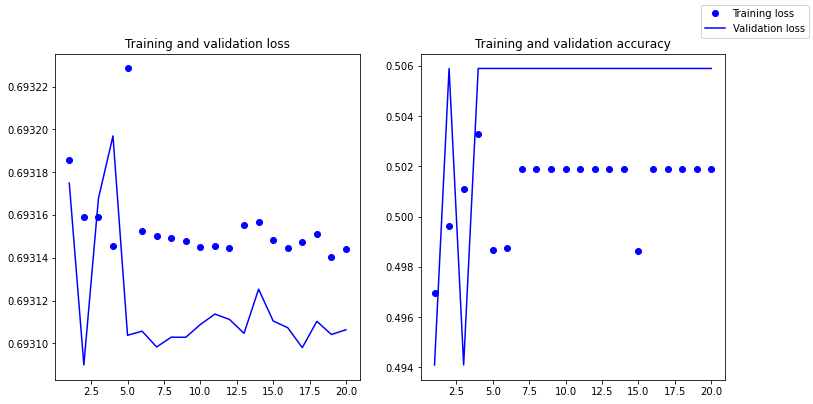

In [31]:
history_dict3 = history3.history


import matplotlib.pyplot as plt


acc3 = history_dict3['accuracy']

val_acc3 = history_dict3['val_accuracy']


loss3 = history_dict3['loss']


val_loss3 = history_dict3['val_loss']

epochs = range(1, len(acc3) + 1)

fig, axs = plt.subplots(1,2, figsize = (12,6))

axs[0].plot(epochs, loss3, 'bo', label='Training loss')
axs[0].plot(epochs, val_loss3, 'b', label='Validation loss')
axs[0].set_title('Training and validation loss')

axs[1].plot(epochs, acc3, 'bo')
axs[1].plot(epochs, val_acc3, 'b')
axs[1].set_title('Training and validation accuracy')



fig.legend()